In [80]:
root_path = 'C:\\...\\Supervised-ML-BankPrediction-Classification\\data\\'

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
import mlflow
import mlflow.sklearn
import numpy as np

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


seed = 42

In [82]:
df = pd.read_csv(root_path + 'bank_marketing_campaign.csv')
df.head()

,age,job,marital,education,default,housing,loan,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


### Data Cleaning and Preprocessing

In [83]:
#Handling "age"" Outliers


df = df[df['age'] <= 85]

In [84]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = seed)

X_train = train_set.drop(['y'], axis = 'columns')
y_train = train_set['y']

X_test = test_set.drop(['y'], axis = 1)
y_test = test_set['y']

In [85]:
def total_cost(y_test, y_preds, threshold = 0.5):
    
    tn, fp, fn, tp = confusion_matrix(y_test == 1, y_preds > threshold).ravel()
    
    cost_fn = fn*2000
    cost_fp = fp*500
    
    return cost_fn + cost_fp

In [86]:
def min_cost_threshold(y_test, y_preds):
    costs = {}
    for threshold in np.arange(0, 1.1, 0.1):
        costs[round(threshold, 1)] = total_cost(y_test, y_preds, threshold)
    min_threshold = min(costs, key=costs.get)
    return costs[min_threshold], min_threshold
    

In [87]:
import mlflow
from pathlib import Path

# Set the MLflow tracking URI

# Use an absolute path
mlflow.set_tracking_uri('file:///c:/.../Supervised-ML-BankPrediction-Classification/mlruns')

In [88]:
# Define MLflow Experiment for Logistic Regression
mlflow.set_experiment("Logistic Regression Experiment")

<Experiment: artifact_location='file:///c:/Users/polin/OneDrive/Documents/GitHub/Supervised-ML-BankPrediction-Classification/mlruns/695049780415577064', creation_time=1723546140572, experiment_id='695049780415577064', last_update_time=1723546140572, lifecycle_stage='active', name='Logistic Regression Experiment', tags={}>

In [89]:
mlflow.end_run()

Registered model 'logistic_regression_pipeline' already exists. Creating a new version of this model...
Created version '3' of model 'logistic_regression_pipeline'.


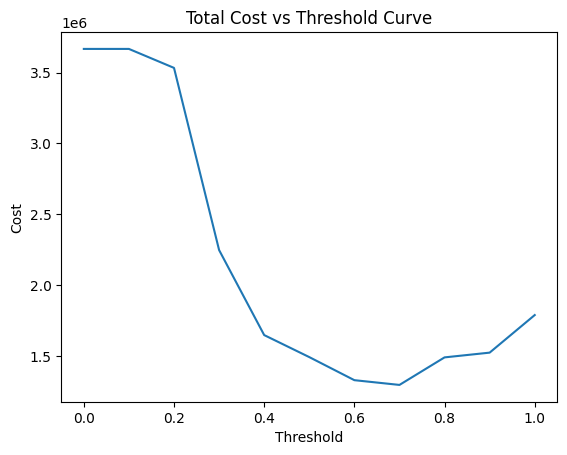

In [90]:
# Define the preprocessing for numerical features
numerical_features = ['age', 'pdays', 'previous', 'emp_var_rate', 
                      'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
numerical_transformer = MinMaxScaler()

# Define the preprocessing for categorical features
categorical_features = ['job', 'marital', 'default', 'housing', 'loan', 'poutcome']
categorical_transformer = OneHotEncoder()

# Ordinal Encoding for 'education'
ordinal_features = ['education']
ordinal_transformer = OrdinalEncoder(categories=[["unknown", "illiterate", "basic.4y", "basic.6y", "basic.9y", 
                                                  "high.school", "professional.course", "university.degree"]])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)
    ])

# PCA
pca = PCA(n_components=14)

# Define the logistic regression model
logistic = LogisticRegression(max_iter=500, solver='lbfgs', random_state=seed, class_weight='balanced')

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('logistic', logistic)
])

# Define hyperparameters for GridSearch
parameters = {'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Use GridSearchCV to find the best hyperparameters


# Logging into MLflow
with mlflow.start_run(run_name="Logistic Regression with Pipeline", nested = True):
    clf_lr = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
    # Fit the model
    clf_lr.fit(X_train, y_train)
    
    # Predict probabilities for test data
    y_probs = clf_lr.predict_proba(X_test)[:, 1]
    
    # Evaluate the logistic regression model
    score = clf_lr.score(X_test, y_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_probs > 0.5).ravel()
    
    # Calculate total cost and minimum cost threshold
    cost, min_threshold = total_cost(y_test, y_probs), min_cost_threshold(y_test, y_probs)
    
    # Log parameters, metrics, and model artifacts with MLflow
    mlflow.log_params(clf_lr.best_params_)
    mlflow.log_metric("accuracy", score)
    mlflow.log_metric("total_cost", cost)
    mlflow.log_metric("min_cost_threshold", min_threshold[0])

     # Plot total cost vs threshold curve
    thresholds = np.arange(0, 1.1, 0.1)
    costs = [total_cost(y_test, y_probs, threshold) for threshold in thresholds]
    plt.plot(thresholds, costs)
    plt.ylabel('Cost')
    plt.xlabel('Threshold')
    plt.title('Total Cost vs Threshold Curve')
    plt.savefig('total_cost_vs_threshold.png')
    mlflow.log_artifact('total_cost_vs_threshold.png')
    
    # Log the final model
    mlflow.sklearn.log_model(clf_lr.best_estimator_, artifact_path="logistic_regression_pipeline", registered_model_name="logistic_regression_pipeline", input_example=X_train)

In [91]:
params=logistic.get_params()
mlflow.log_params(params)
params

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [92]:
mlflow.end_run()